# New York City Taxi Trip Duration Competition
## Share code and data to improve ride time predictions

## 1. Data Extraction

### 1.1 Import libraries

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")


In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%matplotlib inline

import numpy as np
from numpy import random, float
import pandas as pd
from pandas import DataFrame
#from pandas.core import datetools
from pandas.lib import Timestamp

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import tree
from sklearn.metrics import accuracy_score, mean_squared_log_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import math
from math import radians, cos, sin, asin, sqrt
import statsmodels.api as sm
from datetime import datetime

import matplotlib.pyplot as plt
from ggplot import *
import seaborn as sns
from geopy.distance import vincenty #for calculating Distance

pd.options.display.float_format = '{:,.15f}'.format
pd.options.display.max_rows = 100
plt.rcParams['figure.figsize'] = [16, 10]

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1.2 Read data from files.

In [3]:
train = pd.read_csv("train.csv", header = 0)
test = pd.read_csv("test.csv", header = 0)

### Add external data

In [4]:
fr1 = pd.read_csv('Extras/fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
fr2 = pd.read_csv('Extras/fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
test_street_info = pd.read_csv('Extras/fastest_routes_test.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train_street_info = pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')

### 1.3 File structure and content

In [5]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,N,455,"2,009.099999999999909",164.900000000000006,5.000000000000000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,N,663,"2,513.199999999999818",332.000000000000000,6.000000000000000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,N,2124,"11,060.799999999999272",767.600000000000023,16.000000000000000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,N,429,"1,779.400000000000091",235.800000000000011,4.000000000000000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,N,435,"1,614.900000000000091",140.099999999999994,5.000000000000000


In [6]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,total_distance,total_travel_time,number_of_steps
count,"1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,644.000000000000000","1,458,643.000000000000000","1,458,643.000000000000000","1,458,643.000000000000000"
mean,1.534950268879864,1.664529521939555,-73.973486304892816,40.750920908391734,-73.973415946945806,40.751799514900199,959.492272960365881,"4,626.383079135681328",389.371859255478739,7.547126335916328
std,0.498777153905215,1.314242167812239,0.070901858422697,0.032881186257634,0.070643268097204,0.035890555605635,"5,237.431724497701907","5,303.878378487630471",314.467889988712443,4.432503854297273
min,1.000000000000000,0.000000000000000,-121.933341979980483,34.359695434570305,-121.933303833007798,32.181140899658203,1.000000000000000,0.000000000000000,0.000000000000000,2.000000000000000
25%,1.000000000000000,1.000000000000000,-73.991867065429702,40.737346649169922,-73.991325378417969,40.735884666442871,397.000000000000000,"1,666.099999999999909",181.500000000000000,5.000000000000000
50%,2.000000000000000,1.000000000000000,-73.981742858886719,40.754100799560547,-73.979751586914062,40.754524230957031,662.000000000000000,"2,755.099999999999909",289.500000000000000,6.000000000000000
75%,2.000000000000000,2.000000000000000,-73.967330932617188,40.768360137939453,-73.963012695312500,40.769809722900391,"1,075.000000000000000","5,113.800000000000182",490.699999999999989,9.000000000000000
max,2.000000000000000,9.000000000000000,-61.335529327392578,51.881084442138672,-61.335529327392578,43.921028137207031,"3,526,282.000000000000000","94,204.199999999997090","5,135.399999999999636",46.000000000000000


In [7]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
total_distance        float64
total_travel_time     float64
number_of_steps       float64
dtype: object

In [8]:
train.shape

(1458644, 14)

In [9]:
test.shape

(625134, 12)

In [10]:
test.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
total_distance        float64
total_travel_time     float64
number_of_steps         int64
dtype: object

### 1.4 Missing values

In [11]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [12]:
train = train.dropna()

In [13]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
total_distance        0
total_travel_time     0
number_of_steps       0
dtype: int64

In [14]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
total_distance        0
total_travel_time     0
number_of_steps       0
dtype: int64

Re-formulate Date columns from two datasets.

In [15]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test


## 2. Exploratory Data Analysis

### 2.1 Data Overview

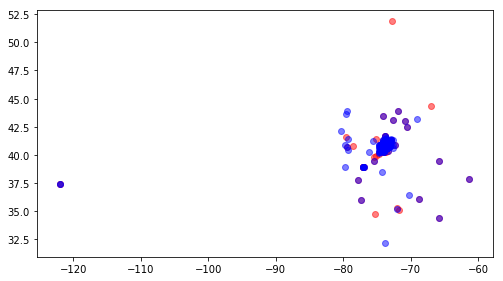

In [16]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)

plt.scatter(train['pickup_longitude'], train['pickup_latitude'], c='red', alpha=0.5)
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], c='blue', alpha=0.5)

#sns.regplot(x='pickup_longitude',y='pickup_latitude',data=combined,scatter=True, color='red', fit_reg=False, ax=ax1)
#sns.regplot(x='dropoff_longitude',y='dropoff_latitude',data=combined,scatter=True, color='blue', fit_reg=False, ax=ax1)


There are some extreme outliers in the location data. We need to remove them to make the predictions meaningful.

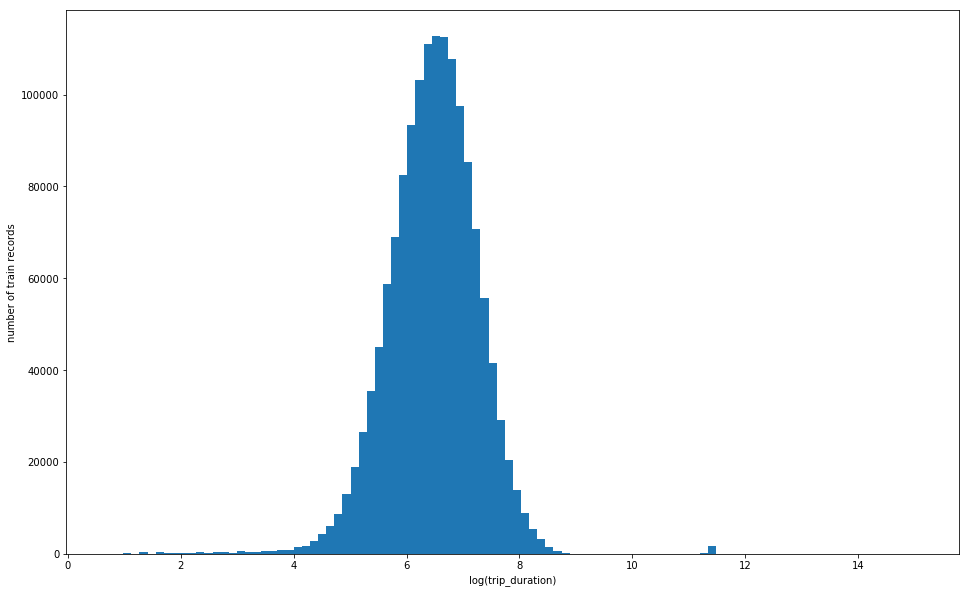

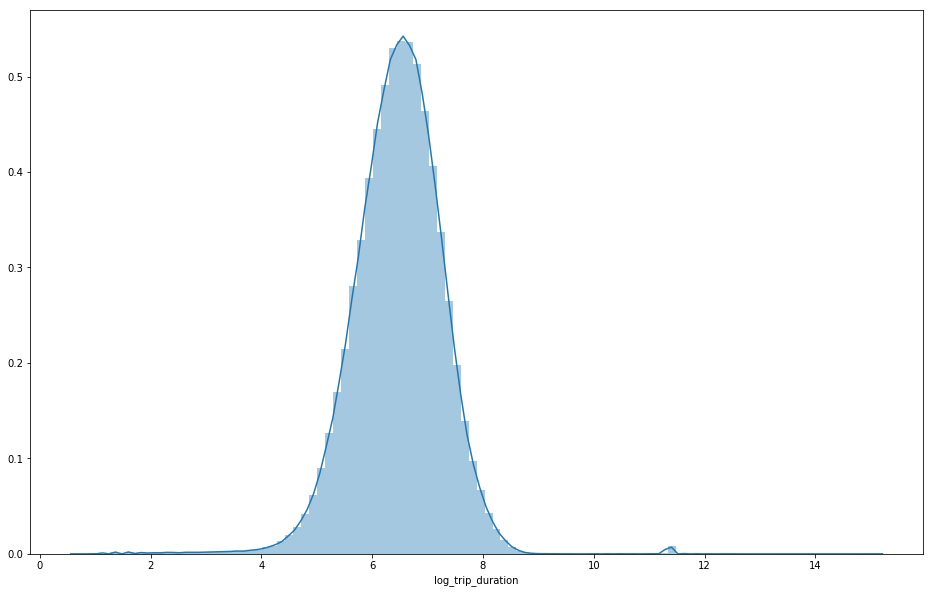

In [17]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

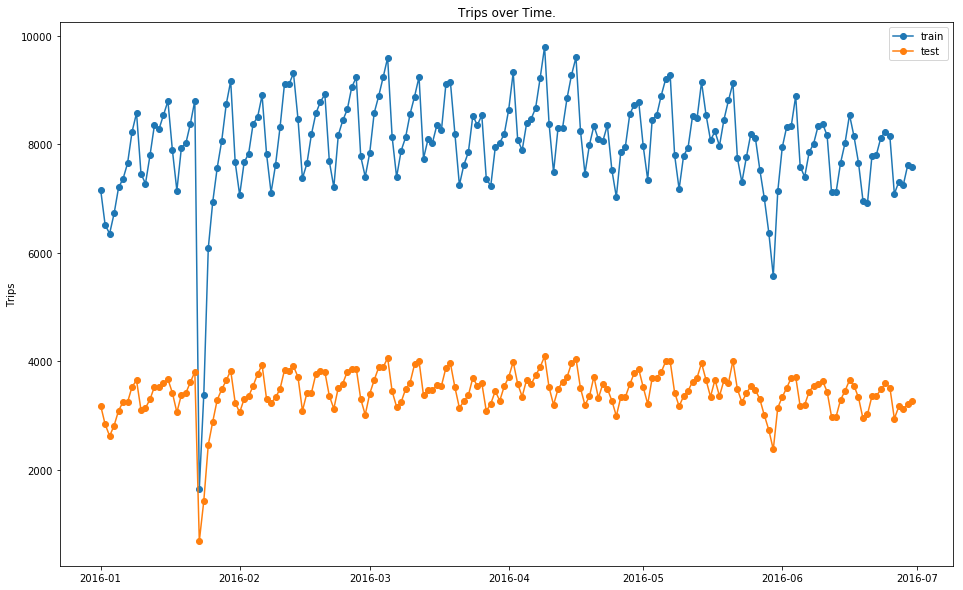

In [18]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

### 2.2 Clean data, remove outliers
### Distance outliers

The borders of NewYork City

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

In [19]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

### Calculate Distance

In [20]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'Y':1 , 'N':0, 1:1, 0:0})
train['trip_distance'] = train.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])).feet, axis=1).astype(int)

{'boxes': [<matplotlib.lines.Line2D at 0x1daabbdab38>],
 'caps': [<matplotlib.lines.Line2D at 0x1daabbd2160>,
 'fliers': [<matplotlib.lines.Line2D at 0x1dab3d04710>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1dab3d041d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1daabbda8d0>,
  <matplotlib.lines.Line2D at 0x1daabbd21d0>]}

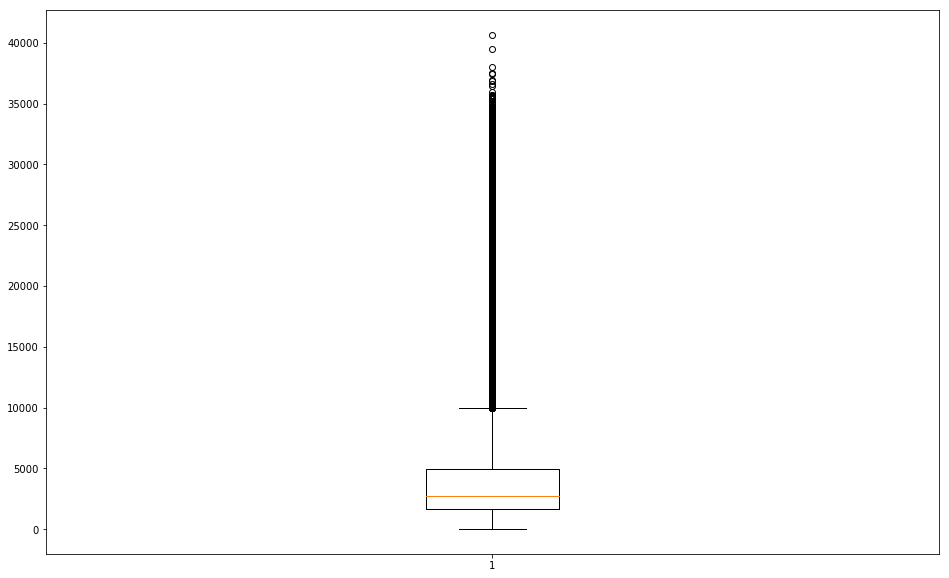

In [21]:
plt.boxplot(x=train['total_distance'], vert=True)

### Duration outliers

{'boxes': [<matplotlib.lines.Line2D at 0x1daa9c6e0b8>],
 'caps': [<matplotlib.lines.Line2D at 0x1daa9c69f28>,
 'fliers': [<matplotlib.lines.Line2D at 0x1daba9ca438>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1daa9c612e8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1daa9c6e9e8>,
  <matplotlib.lines.Line2D at 0x1daa9c6e940>]}

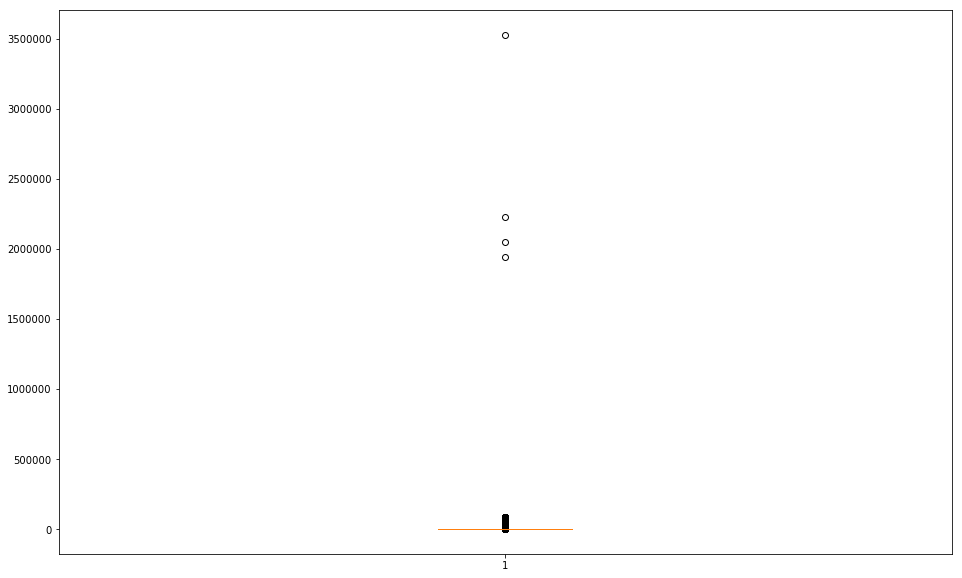

In [22]:
plt.boxplot(x=train['trip_duration'], vert=True)

Clearly there are some suspiciously long duration trips which need to be removed to have some meaningful analysis.

In [23]:
train = train[(train.trip_duration < 100000)]

{'boxes': [<matplotlib.lines.Line2D at 0x1daa0044400>],
 'caps': [<matplotlib.lines.Line2D at 0x1da9cc9d9b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1da9cc90940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1da9cc960b8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1daa0044eb8>,
  <matplotlib.lines.Line2D at 0x1daa0044dd8>]}

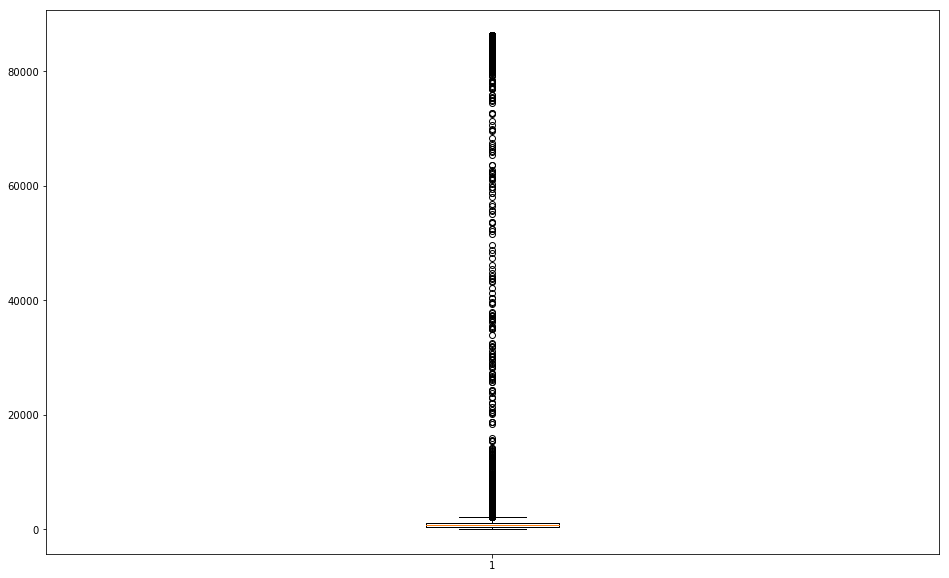

In [24]:
plt.boxplot(x=train['trip_duration'], vert=True)

Finally, the taxi trip distance gives us a normal distribution curve.

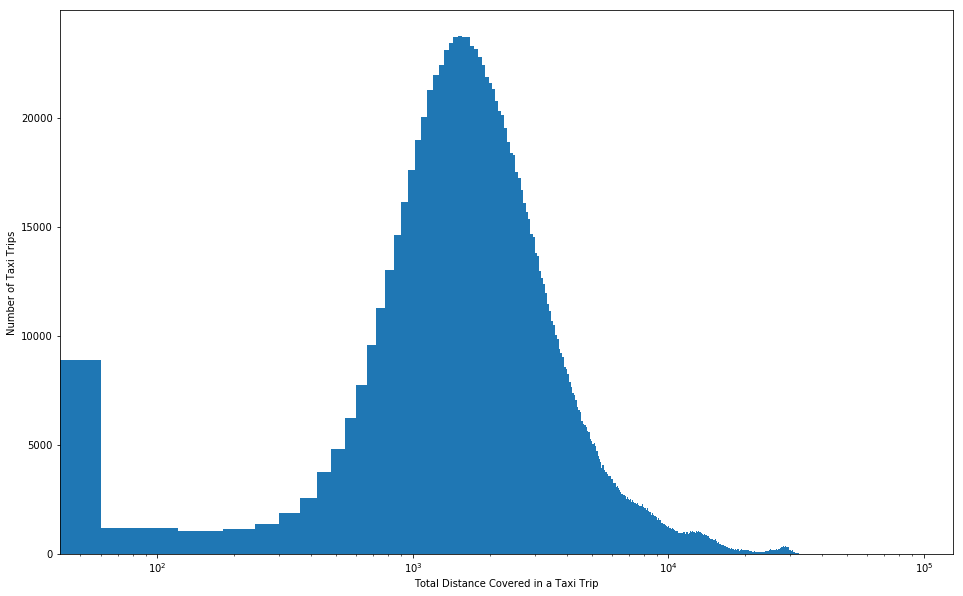

In [25]:
p = plt.hist(train['total_distance'], bins=1500, range=(0,90000))
plt.xlabel("Total Distance Covered in a Taxi Trip")
plt.ylabel("Number of Taxi Trips")
plt.xscale('log')

### 2.3 Feature engineering, date extraction

In [26]:
#Extracting Month
train['Month'] = pd.DatetimeIndex(pd.to_datetime(train['pickup_datetime'])).month
test['Month'] = pd.DatetimeIndex(pd.to_datetime(test['pickup_datetime'])).month

In [27]:
train.groupby('Month').size(),test.groupby('Month').size()

(Month
 1    226762
 2    235368
 3    252812
 4    248210
 5    244940
 6    231086
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [28]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [29]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [30]:
train['DayofWeek'] = train['pickup_datetime'].dt.dayofweek
test['DayofWeek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('DayofWeek').size()),len(test.groupby('DayofWeek').size())

(7, 7)

### Creating dummy variables

In [31]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['DayofWeek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['DayofWeek'], prefix='dow', prefix_sep='_')

### 2.4 Finding Data Correlations

### No. of taxi pickups over the various days

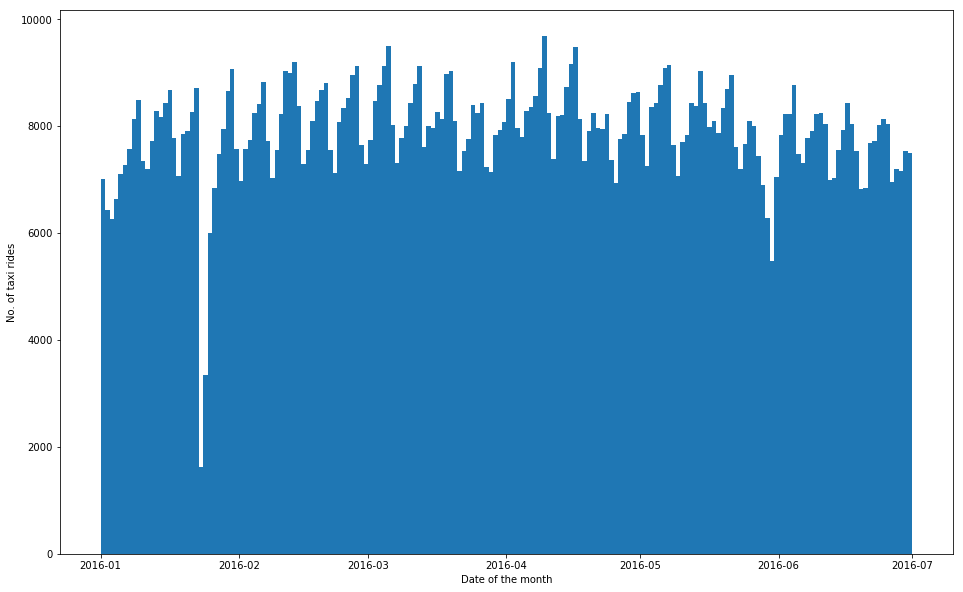

In [32]:
#combined.groupby(combined['pickup_datetime'].dt.month).count().plot(kind="bar")
#combined['pickup_datetime'].count()# .plot(kind="bar")
plt.hist(train.pickup_datetime.values, bins=182 )
plt.xlabel("Date of the month")
plt.ylabel("No. of taxi rides")

Some days of the year have exceptionally less number of taxi rides, possibly due to bad weather conditions. Introducing external weather data will be quite useful.

### No. of passengers related to taxi trip duration

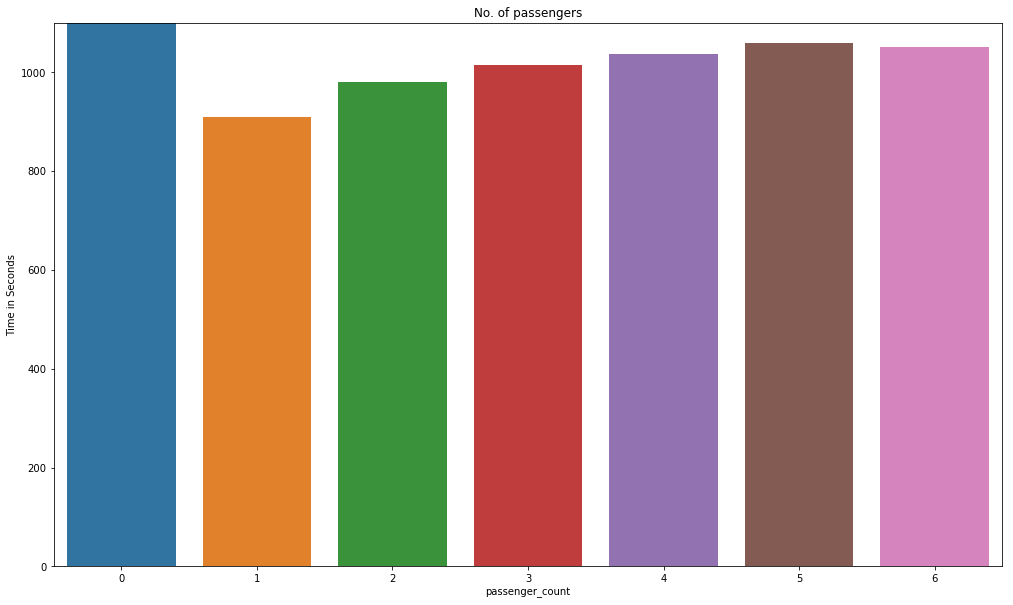

In [33]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('No. of passengers')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

### Hour of the day related to taxi trip duration

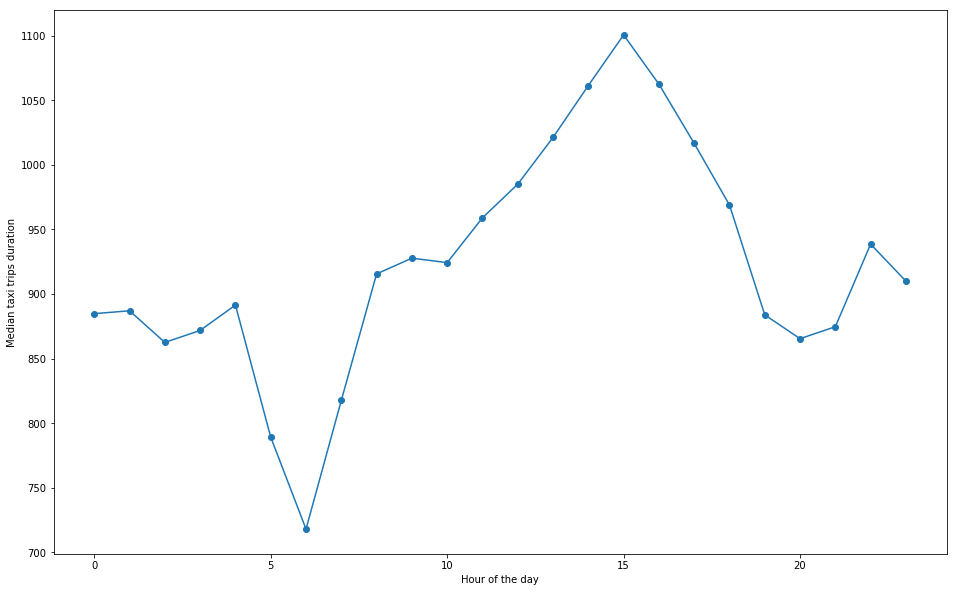

In [34]:
hr = train.groupby('Hour')['trip_duration'].mean()
plt.plot(hr, 'o-')
plt.xlabel("Hour of the day")
plt.ylabel("Median taxi trips duration")

This is definitely a very important feature to consider that not only affects the number of taxi trips but also the duration of those trips.

### Day of the week related to taxi trip durations

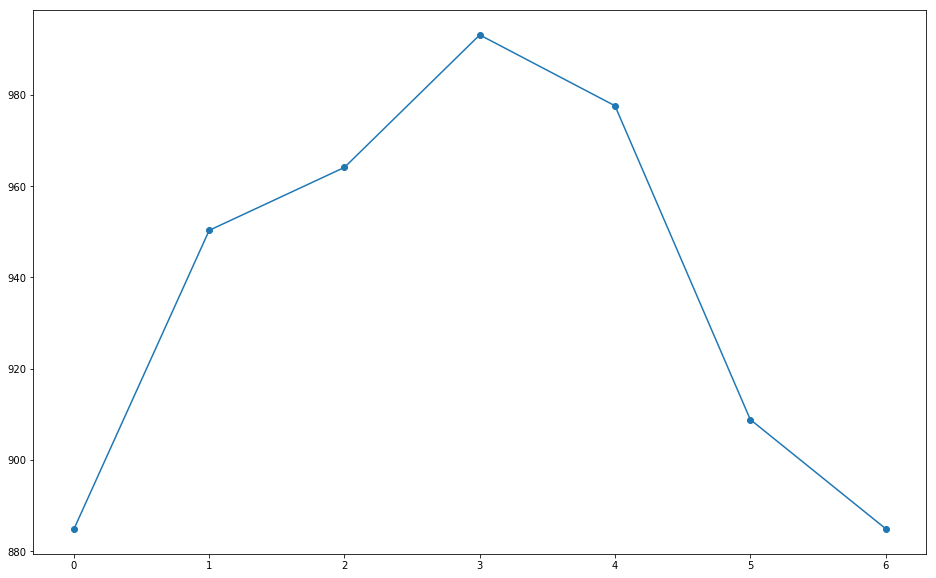

In [35]:
dwk = train.groupby('DayofWeek')['trip_duration'].mean()
plt.plot(dwk, 'o-')

Day of the week is definitely an important factor to consider while predicting the average taxi trip duration.

## 3. Modeling

### 3.1 Preparing the data

### Drop fields
Finally, drop the non-numeric columns in preparation for modeling and algorithm training.

In [36]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_distance,total_travel_time,number_of_steps,pickup_date,log_trip_duration,trip_distance,Month,DayofMonth,Hour,DayofWeek
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,...,"2,009.099999999999909",164.900000000000006,5.000000000000000,2016-03-14,6.122492809514386,6421,3,14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415344238267,40.738563537597656,-73.999481201171875,40.731151580810547,0,...,"2,513.199999999999818",332.000000000000000,6.000000000000000,2016-06-12,6.498282149476434,7021,6,12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979026794433580,40.763938903808594,-74.005332946777344,40.710086822509773,0,...,"11,060.799999999999272",767.600000000000023,16.000000000000000,2016-01-19,7.661527081358517,11062,1,19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040283203125,40.719970703125000,-74.012268066406250,40.706718444824219,0,...,"1,779.400000000000091",235.800000000000011,4.000000000000000,2016-04-06,6.063785208687608,1566,4,6,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973052978515625,40.793209075927727,-73.972923278808594,40.782520294189453,0,...,"1,614.900000000000091",140.099999999999994,5.000000000000000,2016-03-26,6.077642243349034,1082,3,26,13,5
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982856750488295,40.742195129394531,-73.992080688476562,40.749183654785156,0,...,"1,393.500000000000000",189.400000000000006,5.000000000000000,2016-01-30,6.095824562432225,3450,1,30,22,5
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017028808594,40.757839202880852,-73.957405090332031,40.765895843505852,0,...,"1,705.099999999999909",138.800000000000011,5.000000000000000,2016-06-17,5.834810737062605,4329,6,17,22,4
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276428222656,40.797779083251953,-73.922470092773438,40.760559082031250,0,...,"10,642.000000000000000",769.200000000000045,17.000000000000000,2016-05-21,7.347299700743164,17548,5,21,7,5
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481201171875,40.738399505615227,-73.985786437988295,40.732814788818359,0,...,"1,310.700000000000045",160.599999999999994,2.000000000000000,2016-05-27,5.545177444479562,5046,5,27,23,4
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981048583984375,40.744338989257812,-73.972999572753906,40.789989471435547,0,...,"6,786.800000000000182",601.799999999999955,13.000000000000000,2016-03-10,7.111512116496157,5476,3,10,21,3


In [37]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','DayofWeek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','DayofWeek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','trip_duration'], axis = 1)

### Add new fields

Now let's add the indicator variables to our datasets.

In [38]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          month_train,
                          dom_train,
                          hour_train,
                          dow_train
                         ], axis=1)

Test_Master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         month_test,
                         dom_test,
                         hour_test,
                         dow_test
                        ], axis=1)

In [39]:
Train_Master.shape,Test_master.shape

((1439178, 86), (625134, 85))

In [40]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_Master = Test_Master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [41]:
Train_Master.shape,Test_Master.shape

((1439178, 84), (625134, 83))

In [58]:
Train_Master

,total_distance,total_travel_time,number_of_steps,log_trip_duration,trip_distance,vi_1,vi_2,pc_0,pc_1,pc_2,...,h_21,h_22,h_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,"2,009.099999999999909",164.900000000000006,5.000000000000000,6.122492809514386,6421,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,"2,513.199999999999818",332.000000000000000,6.000000000000000,6.498282149476434,7021,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,"11,060.799999999999272",767.600000000000023,16.000000000000000,7.661527081358517,11062,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,"1,779.400000000000091",235.800000000000011,4.000000000000000,6.063785208687608,1566,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,"1,614.900000000000091",140.099999999999994,5.000000000000000,6.077642243349034,1082,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,"1,393.500000000000000",189.400000000000006,5.000000000000000,6.095824562432225,3450,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
6,"1,705.099999999999909",138.800000000000011,5.000000000000000,5.834810737062605,4329,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
7,"10,642.000000000000000",769.200000000000045,17.000000000000000,7.347299700743164,17548,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
8,"1,310.700000000000045",160.599999999999994,2.000000000000000,5.545177444479562,5046,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
9,"6,786.800000000000182",601.799999999999955,13.000000000000000,7.111512116496157,5476,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0


In [59]:
Test_Master

NameError: name 'Test_Master' is not defined

### 3.2 Model training

### Train/Validation Split

In [43]:
Train, Valid = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [44]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_valid = Valid.drop(['log_trip_duration'], axis=1)
Y_valid = Valid["log_trip_duration"]

Y_valid = Y_valid.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

### XGBoost setup

In [45]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_valid, label=Y_valid)
dtest = xgb.DMatrix(Test_Master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [46]:
md = [6]
lr = [.1,.3]
mcw = [20,25,30]

In [47]:
for m in md:
    for l in lr:
        for n in mcw:
            t0 = datetime.now()
            print(m,l,n)
            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 'max_depth': m, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=1)

6 0.1 20
[0]	train-rmse:5.41247	valid-rmse:5.3992
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.87575	valid-rmse:4.8629
[2]	train-rmse:4.39321	valid-rmse:4.38067
[3]	train-rmse:3.95934	valid-rmse:3.94716
[4]	train-rmse:3.56946	valid-rmse:3.55755
[5]	train-rmse:3.21913	valid-rmse:3.20739
[6]	train-rmse:2.9045	valid-rmse:2.89296
[7]	train-rmse:2.622	valid-rmse:2.61063
[8]	train-rmse:2.36853	valid-rmse:2.35738
[9]	train-rmse:2.14126	valid-rmse:2.13034
[10]	train-rmse:1.93767	valid-rmse:1.92687
[11]	train-rmse:1.75539	valid-rmse:1.7448
[12]	train-rmse:1.59235	valid-rmse:1.582
[13]	train-rmse:1.44698	valid-rmse:1.43679
[14]	train-rmse:1.31734	valid-rmse:1.30736
[15]	train-rmse:1.20203	valid-rmse:1.19221
[16]	train-rmse:1.09985	valid-rmse:1.09022
[17]	train-rmse:1.00933	valid-rmse:0.99997
[18]	train-rmse:0.92946	valid-rmse:0.920434
[19]	train-rmse:0.859108	valid-rmse:0.85028
[2

[24]	train-rmse:0.42238	valid-rmse:0.4296
[25]	train-rmse:0.421236	valid-rmse:0.429293
[26]	train-rmse:0.420388	valid-rmse:0.42893
[27]	train-rmse:0.4198	valid-rmse:0.42864
[28]	train-rmse:0.418955	valid-rmse:0.428072
[29]	train-rmse:0.41846	valid-rmse:0.427909
[30]	train-rmse:0.417702	valid-rmse:0.428368
[31]	train-rmse:0.41704	valid-rmse:0.428088
[32]	train-rmse:0.416147	valid-rmse:0.428185
[33]	train-rmse:0.415506	valid-rmse:0.428565
[34]	train-rmse:0.414688	valid-rmse:0.42851
[35]	train-rmse:0.414206	valid-rmse:0.428496
[36]	train-rmse:0.413686	valid-rmse:0.428785
[37]	train-rmse:0.412976	valid-rmse:0.428558
[38]	train-rmse:0.412349	valid-rmse:0.428593
[39]	train-rmse:0.411634	valid-rmse:0.428136
Stopping. Best iteration:
[29]	train-rmse:0.41846	valid-rmse:0.427909

6 0.3 25
[0]	train-rmse:4.22097	valid-rmse:4.20845
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.97409	

In [53]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 'max_depth': 6,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22085	valid-rmse:4.20827
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.97385	valid-rmse:2.96241
[2]	train-rmse:2.10829	valid-rmse:2.09773
[3]	train-rmse:1.51199	valid-rmse:1.50202
[4]	train-rmse:1.10745	valid-rmse:1.09824
[5]	train-rmse:0.839488	valid-rmse:0.831853
[6]	train-rmse:0.668845	valid-rmse:0.663268
[7]	train-rmse:0.565555	valid-rmse:0.561767
[8]	train-rmse:0.506044	valid-rmse:0.504
[9]	train-rmse:0.472924	valid-rmse:0.472622
[10]	train-rmse:0.454347	valid-rmse:0.455723
[11]	train-rmse:0.443987	valid-rmse:0.447218
[12]	train-rmse:0.437741	valid-rmse:0.442475
[13]	train-rmse:0.433506	valid-rmse:0.439591
[14]	train-rmse:0.430604	valid-rmse:0.438169
[15]	train-rmse:0.427553	valid-rmse:0.436518
[16]	train-rmse:0.425271	valid-rmse:0.435524
[17]	train-rmse:0.423604	valid-rmse:0.434776
[18]	train-rmse:0.421051	valid-rmse:0.433658
[19]	train-rmse:0.41912

### Evaluation

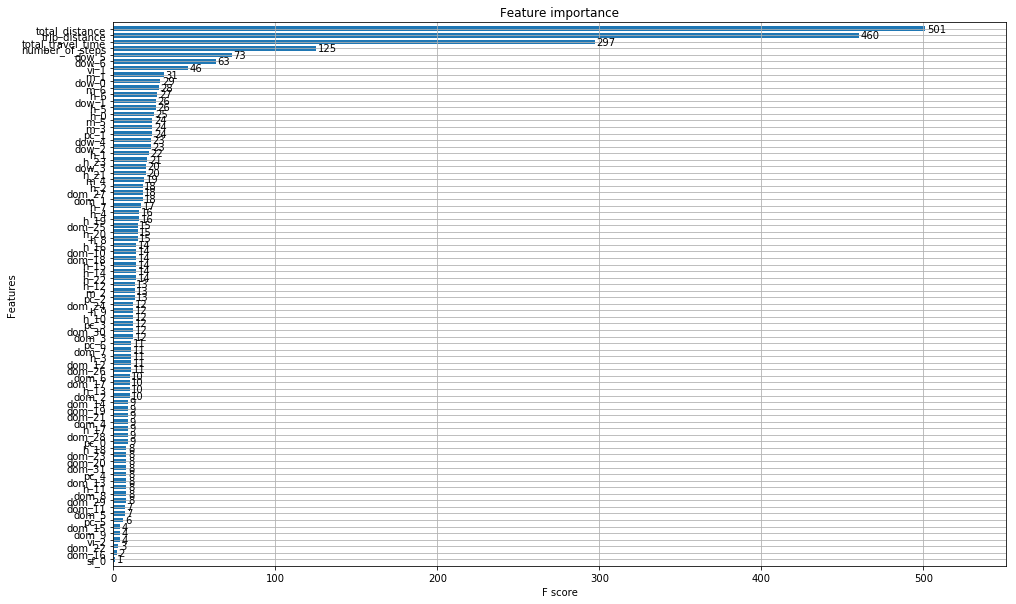

In [55]:
xgb.plot_importance(model, height=0.7)


### 3.3 Prediction and saving results

In [57]:
pred = model.predict(dtest)

ValueError: feature_names mismatch: ['total_distance', 'total_travel_time', 'number_of_steps', 'trip_distance', 'vi_1', 'vi_2', 'pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'sf_0', 'sf_1', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11', 'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18', 'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25', 'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6'] ['total_distance', 'total_travel_time', 'number_of_steps', 'vi_1', 'vi_2', 'pc_0', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'pc_6', 'pc_9', 'sf_N', 'sf_Y', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11', 'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18', 'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25', 'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31', 'h_0', 'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10', 'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19', 'h_20', 'h_21', 'h_22', 'h_23', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
expected trip_distance, sf_1, sf_0 in input data
training data did not have the following fields: sf_Y, sf_N, pc_9

In [ ]:
pred = np.exp(pred) - 1

### Save CSV

In [150]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)

In [151]:
test_raw['store_and_fwd_flag'] = test_raw['store_and_fwd_flag'].map({'Y':1 , 'N':0, 1:1, 0:0})
test_raw['total_distance'] = test_raw.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'], x['dropoff_latitude'])).feet, axis=1).astype(int)
test_raw['pickup_datetime'] = pd.to_datetime(test_raw['pickup_datetime'])

In [152]:
test1 = test_raw.drop(['id','Date','Events','pickup_datetime','pickup_date'], axis=1)

In [153]:
test1.shape

(625134, 32)

In [154]:
res = clf.predict(test1)

In [179]:
res1 = pd.DataFrame()

In [180]:
res1['id'] = test.id

In [181]:
res1['trip_duration'] = res

In [201]:
res1

,id,trip_duration
0,id3004672,625.120000000000005
1,id3505355,756.500000000000000
2,id1217141,527.559999999999945
3,id2150126,"1,100.619999999999891"
4,id1598245,429.839999999999975
5,id0668992,740.879999999999995
6,id1765014,"1,244.259999999999991"
7,id0898117,"1,057.420000000000073"
8,id3905224,"4,242.140000000000327"
9,id1543102,559.100000000000023


In [184]:
res1.to_csv("kaggle-taxi-res.csv")

In [ ]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [828]:
combined.dtypes

vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
pickup_date                   object
pickup_hour                    int64
pickup_minute                  int64
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
visavg                         int64
v

### Make a separate column for Month and Date

In [18]:
df['Date']=df['pickup_datetime'].dt.year.map(str)+'-'+df['pickup_datetime'].dt.month.map(str)+'-'+df['pickup_datetime'].dt.day.map(str)
df['Date']=pd.to_datetime(df['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])

df_w.head()
#print("The deed is done")

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


### Let's join weather data:

In [19]:
df_join=df[df['within_min_range']<130].merge(df_w, on='Date', how='inner')

print("The deed is done")
df_join.head()

The deed is done


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191392,40.767936706542969,-73.964630126953125,40.765602111816406,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090026855469,40.758766174316406,-73.953201293945312,40.765068054199219,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
2,id0256505,1,2016-03-14 15:04:38,2016-03-14 15:16:13,1,-73.994483947753906,40.745086669921882,-73.998992919921875,40.722709655761719,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
3,id3863815,2,2016-03-14 04:24:36,2016-03-14 04:37:11,3,-73.944358825683580,40.714488983154297,-73.910530090332031,40.709491729736328,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000
4,id3817493,2,2016-03-14 14:57:56,2016-03-14 15:15:26,1,-73.952880859375000,40.766468048095696,-73.978630065917969,40.761920928955078,0,...,10,8,3,24,13,37,0.000000000000000,,0.290000000000000,0.000000000000000


## Data Analysis

### Check which columns are numeric in data

### Data types:

In [20]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
dtype: object

In [21]:
df_join.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

### Finding missing values:

In [22]:
df.count() 

id                    1458644
vendor_id             1458644
pickup_datetime       1458644
dropoff_datetime      1458644
passenger_count       1458644
pickup_longitude      1458644
pickup_latitude       1458644
dropoff_longitude     1458644
dropoff_latitude      1458644
store_and_fwd_flag    1458644
trip_duration         1458644
within_min_range      1458644
total_distance        1458644
Date                  1458644
dtype: int64

So we have do not have any missing data in this data set.

### Data range for data

In [23]:
print("pickup_datetime min is " + str(df['pickup_datetime'].min()) + " and max is " + str(df['pickup_datetime'].max()))
print("dropoff_datetime min is " + str(df['dropoff_datetime'].min()) + " and max is " + str(df['dropoff_datetime'].max()))
print("trip_duration min is " + str(df['trip_duration'].min()) + " and max is " + str(df['trip_duration'].max()))
#print df.loc[[978383]]


pickup_datetime min is 2016-01-01 00:00:17 and max is 2016-06-30 23:59:39
dropoff_datetime min is 2016-01-01 00:03:31 and max is 2016-07-01 23:02:03
trip_duration min is 1 and max is 3526282


### Let's see if we have uniqueness in data

In [24]:
df.apply(pd.Series.nunique)



id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
within_min_range           25
total_distance          72615
Date                      182
dtype: int64

### Strip Off Non Numeric Columns

In [25]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nonnumeric_cols=df_join.select_dtypes(exclude=numerics).columns.values
print("Non numeric columns to look out for: " + str(nonnumeric_cols))

Non numeric columns to look out for: ['id' 'pickup_datetime' 'dropoff_datetime' 'Date' 'Events']


### Do we need these? Let's say no for now

In [20]:
#df_join = df_join.drop(['id','pickup_datetime','dropoff_datetime','Events'],axis=1)
print("Non-numeric columns dropped")


Non-numeric columns dropped


In [31]:
df_join.dtypes
#df_join["id"]

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

### Fixing missing values..

Let's see if we have any missing values anywhere

In [32]:
df_join.isnull().values.any()

False

### Free up Memory

In [23]:
#Release memory
del df
#del df_join

# Visualization:

Let us see now if there is any relationship between average monthly temperature versus trip duration and total_distance

In [33]:
#Aggregation and Joins:
df_bar = df_join.groupby('tempavg', as_index=False)['trip_duration','total_distance'].mean()

df_bar_count21 = df_join.groupby(['tempavg','Date'], as_index=False)['id'].count()
df_bar_count = df_bar_count21.groupby(['tempavg'], as_index=False)['id'].sum()
df_bar_join=df_bar.merge(df_bar_count, on='tempavg', how='inner')


Correlation between average daily temperature and total trip duration covered is: 0.645687235493
Correlation between average daily temperature and total distance covered is: 0.488147161639
Correlation between average daily temperature and total rides is: 0.0702330533882


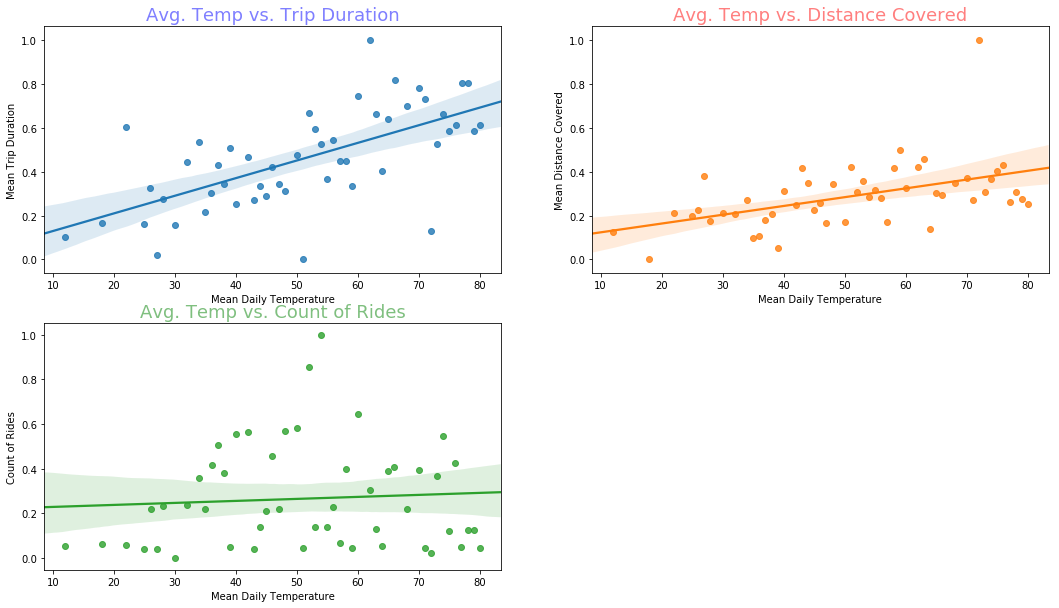

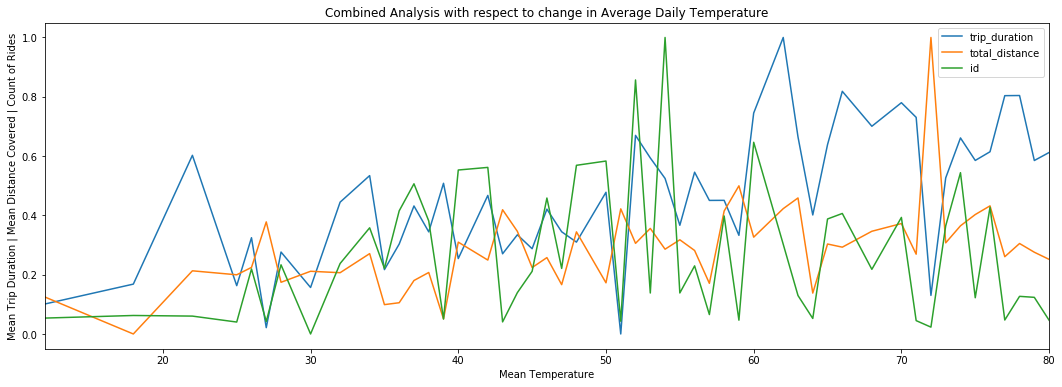

In [34]:
#Scaling:
features_to_scale = ['trip_duration','total_distance','id']
df_bar_join[features_to_scale] -= df_bar_join[features_to_scale].min()  # equivalent to df = df - df.min()
df_bar_join[features_to_scale] /= df_bar_join[features_to_scale].max() 

#Plotting:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar_join,fit_reg=True, ax=ax1)
sns.regplot(x='tempavg',y='total_distance',data=df_bar_join,fit_reg=True, ax=ax2)
sns.regplot(x='tempavg',y='id',data=df_bar_join,fit_reg=True, ax=ax3)

ax1.set(xlabel='Mean Daily Temperature', ylabel='Mean Trip Duration')
ax2.set(xlabel='Mean Daily Temperature', ylabel='Mean Distance Covered')
ax3.set(xlabel='Mean Daily Temperature', ylabel='Count of Rides')
ax1.set_title('Avg. Temp vs. Trip Duration', fontsize=18,color="b",alpha=0.5)
ax2.set_title('Avg. Temp vs. Distance Covered', fontsize=18,color="r",alpha=0.5)
ax3.set_title('Avg. Temp vs. Count of Rides', fontsize=18,color="g",alpha=0.5)

#Combined Graph:
ax = df_bar_join.plot(x='tempavg',figsize=(18, 6),title = 'Combined Analysis with respect to change in Average Daily Temperature')
ax.set_ylabel('Mean Trip Duration | Mean Distance Covered | Count of Rides')
ax.set_xlabel('Mean Temperature')

#Coorelation Analysis:
print('Correlation between average daily temperature and total trip duration covered is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['trip_duration'])))
print('Correlation between average daily temperature and total distance covered is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['total_distance'])))
print('Correlation between average daily temperature and total rides is: '+ str(pd.to_numeric(df_bar_join['tempavg']).corr(df_bar_join['id'])))


We can make three assumptions here:

When the average daily goes up, there is gradual increase in :

1- Total distance covered is slightly correlated to increase in temperature
2- Total trip Duration is relatively more correlated to increase in temperature
3- Temperature increase does not have any significant impact on total number of rides

Keeping in view point number 3, we can attribute total increase in duration and distance to increase in traffic. Causes for this increase are ambiguous at this point. Something to work on for future

Now, lets do some **Vendor Analysis**

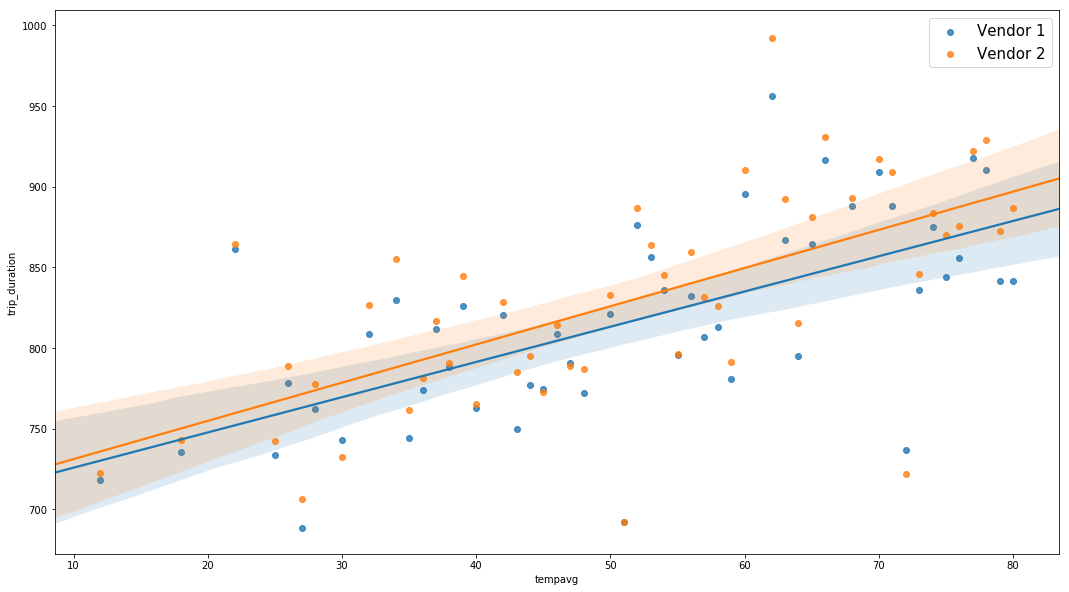

In [35]:
df_bar = df_join.groupby(['tempavg','vendor_id'], as_index=False)['trip_duration'].mean()

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==1],fit_reg=True, ax=ax1, label = 'Vendor 1')
sns.regplot(x='tempavg',y='trip_duration',data=df_bar[df_bar['vendor_id']==2],fit_reg=True, ax=ax1, label = 'Vendor 2')
ax1.legend(loc=1, prop={'size': 15})


Not much behavior difference between the two vendors with respect to temperature

# Train/Test split

In [36]:
np.random.seed()
msk = np.random.rand(len(df_join)) < 0.8
dfTrain = df_join[msk]
dfTest = df_join[~msk]

print(len(dfTrain))
print(len(dfTest))

1165014
291377


# Multi Variate Regression Analysis

Let's build and MVR

In [37]:
df_Train_features = pd.DataFrame(dfTrain.copy())
df_Train_features = df_Train_features.drop(['trip_duration','Date','within_min_range'],axis=1)
features = list(df_Train_features.columns[1:])
del df_Train_features
features

 

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'total_distance',
 'temphigh',
 'tempavg',
 'templow',
 'dewhigh',
 'dewavg',
 'dewlow',
 'humhigh',
 'humavg',
 'humlow',
 'seahigh',
 'seaavg',
 'sealow',
 'vishigh',
 'visavg',
 'vislow',
 'windhigh',
 'windavg',
 'preceiphigh',
 'precipsum',
 'Events',
 'Precip',
 'Snow']

Prepare for clustering the pickup coordinates:

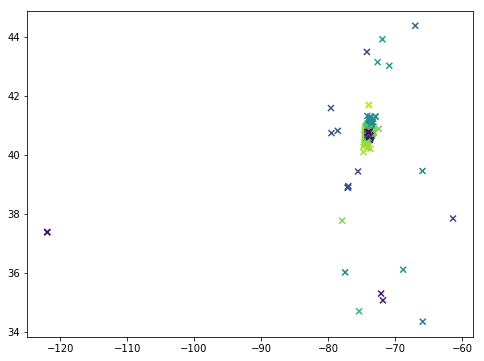

In [38]:
model = KMeans(n_clusters=50)
model = model.fit(scale(dfTrain[['pickup_longitude', 'pickup_latitude']]))
plt.figure(figsize=(8, 6))
plt.scatter(dfTrain['pickup_longitude'], dfTrain['pickup_latitude'], c=model.labels_.astype(float),marker='x')

Prepare for clustering the dropoff coordinates:

In [39]:
dfTrain.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
trip_duration                  int64
within_min_range               int64
total_distance                 int32
Date                  datetime64[ns]
temphigh                       int64
tempavg                        int64
templow                        int64
dewhigh                        int64
dewavg                         int64
dewlow                         int64
humhigh                        int64
humavg                         int64
humlow                         int64
seahigh                      float64
seaavg                       float64
sealow                       float64
vishigh                        int64
v

MVR starts here

In [40]:
features=['vendor_id','passenger_count','store_and_fwd_flag','total_distance','temphigh','tempavg','templow','dewhigh','dewavg','dewlow','humhigh','humavg','humlow','vishigh','visavg','vislow','windhigh','windavg','preceiphigh']
X = scale(dfTrain[features])
y = dfTrain['trip_duration']

clf = ExtraTreesRegressor()
est = clf.fit(X,y)

clf.score(scale(dfTest[features]),dfTest['trip_duration'])

#est.summary()

0.33505831101003536

# Test- Mania

In [44]:
test_file = "test.csv"
df_Test = pd.read_csv(test_file, header = 0)

df_Test['pickup_datetime'] = pd.to_datetime(df_Test['pickup_datetime'])
#df_Test['dropoff_datetime'] = pd.to_datetime(df_Test['dropoff_datetime'])
df_w['Date'] = pd.to_datetime(df_w['Date'])

d={'Y':1 , 'N':0}
df_Test['store_and_fwd_flag'] = df_Test['store_and_fwd_flag'].map(d)
df_Test['total_distance'] = df_Test.apply(lambda x: vincenty((x['pickup_longitude'],x['pickup_latitude']), (x['dropoff_longitude'],   x['dropoff_latitude'])).feet, axis=1).astype(int)

df_Test['Date']=df_Test['pickup_datetime'].dt.year.map(str)+'-'+df_Test['pickup_datetime'].dt.month.map(str)+'-'+df_Test['pickup_datetime'].dt.day.map(str)
df_Test['Date']=pd.to_datetime(df_Test['Date'])
df_w['Date']=pd.to_datetime(df_w['Date'])


In [52]:

df_Test.dtypes
#df_Test.head()

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag             int64
total_distance                 int32
Date                  datetime64[ns]
dtype: object

In [53]:
df_w.head()

,Date,temphigh,tempavg,templow,dewhigh,dewavg,dewlow,humhigh,humavg,humlow,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,2016-01-01,44,40,37,32,28,21,70,61,52,...,10,10,8,23,8,39,0.000000000000000,,0.000000000000000,0.000000000000000
1,2016-01-02,42,38,35,27,24,21,70,57,49,...,10,10,9,16,10,34,0.000000000000000,,0.000000000000000,0.000000000000000
2,2016-01-03,48,42,35,28,27,25,70,60,40,...,10,10,8,17,10,33,0.000000000000000,,0.000000000000000,0.000000000000000
3,2016-01-04,37,28,19,28,17,7,74,57,32,...,10,10,8,13,5,28,0.000000000000000,,0.000000000000000,0.000000000000000
4,2016-01-05,35,25,15,18,11,5,93,55,33,...,10,10,9,14,6,40,0.000000000000000,,0.000000000000000,0.000000000000000


In [55]:

df_join_Test=df_Test.merge(df_w, on='Date', how='inner')


df_join_Test.head()


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,...,vishigh,visavg,vislow,windhigh,windavg,preceiphigh,precipsum,Events,Precip,Snow
0,id3004672,1,2016-06-30 23:59:58,1,-73.988128662109375,40.732028961181641,-73.990173339843750,40.756679534912102,0,2600,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
1,id3505355,1,2016-06-30 23:59:53,1,-73.964202880859375,40.679992675781250,-73.959808349609375,40.655403137207031,0,2963,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
2,id1217141,1,2016-06-30 23:59:47,1,-73.997436523437500,40.737583160400391,-73.986160278320298,40.729522705078132,0,4208,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
3,id2150126,2,2016-06-30 23:59:41,1,-73.956069946289062,40.771900177001953,-73.986427307128906,40.730468750000000,0,11879,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000
4,id1598245,1,2016-06-30 23:59:33,1,-73.970214843750000,40.761474609375000,-73.961509704589844,40.755889892578132,0,3237,...,10,10,9,10,4,44,0.000000000000000,,0.000000000000000,0.000000000000000


In [ ]:

df_join_Test = df_join_Test.drop(['id','pickup_datetime','Events'],axis=1)
print("The deed is done")

clf.score(scale(df_join_Test[features]),df_join_Test['trip_duration'])

## Using Random forests

We'll use a random forest of 10 decision trees to predict employment of specific candidate profiles:

In [265]:
from sklearn.feature_selection import RFE

clf = RandomForestClassifier(n_estimators=100) #means make 1000 random forests
clf = clf.fit(X, y)

#dfTest.head()

#dtTrainResults_RF=DataFrame(clf.predict(dfTrain[features]),columns=list([['Survived']]))
dtTestResults_RF=DataFrame(clf.predict(dfTest[features]),columns=list([['Survived']]))

#accuracy_score(dfTrain['Survived'], dtTrainResults_RF['Survived'], sample_weight=None)
accuracy_score(dfTest['Survived'], dtTestResults_RF['Survived'], sample_weight=None)

#RFE#
#rfe = RFE(clf, 3)
#rfe.fit(X, y)
#dtTestResults_RF=DataFrame(clf.predict(dfTest[features]),columns=list([['Survived']]))
#print accuracy_score(dfTest['Survived'], dtTestResults_RF['Survived'], sample_weight=None)

0.81714285714285717

# Results/Testing

Now let's perform prediction on original Test dataset

In [266]:
#Now performing this on real test set
##################
# 1 #Loading file
##################
test_file = "E:/2- GoogleDrive (Total 15GB)/Interests/Machine Learning/Udemy - Data Science and Machine Learning with Python/DataScience/TitanicTest.csv"
dfTestFinal = pd.read_csv(test_file,header=0)

##################
# 2 #Rectifying missing values
##################
d = {'male': 1, 'female': 0}
dfTestFinal['Sex'] = dfTestFinal['Sex'].map(d)
d = {'S': 0, 'Q': 1 ,'C':2}
dfTestFinal['Embarked']=dfTestFinal['Embarked'].map(d)
missFix_Test=dfTestFinal[features]
fill_NaN_Test = Imputer(missing_values=np.nan, strategy='median', axis=1)
imputed_DF_Test = pd.DataFrame(fill_NaN_Test.fit_transform(missFix_Test))
imputed_DF_Test.columns = missFix_Test.columns
imputed_DF_Test.index = missFix_Test.index

##################
# 3 #Performing Prediction
##################
clf.predict(imputed_DF_Test[features])
dtTestResults_RF_Final=DataFrame(clf.predict(imputed_DF_Test[features]),columns=list([['Survived']]))

#RFE#
#rfe.predict(imputed_DF_Test[features])
#dtTestResults_RF_Final=DataFrame(rfe.predict(imputed_DF_Test[features]),columns=list([['Survived']]))

##################
# 4 #Exporting Results
##################
Results_Main = dfTestFinal.join(dtTestResults_RF_Final['Survived'])
results_file = "E:/2- GoogleDrive (Total 15GB)/Interests/Machine Learning/Udemy - Data Science and Machine Learning with Python/DataScience/TitanicResults.csv"
Results_Main.to_csv(results_file)


## Tree Graphical Representation

Display it. Note you need to have pyplot2 installed for this to work.

To read this decision tree, each condition branches left for "true" and right for "false". When you end up at a value, the value array represents how many samples exist in each target value. So value = [0. 5.] mean there are 0 "Not Survived" and 5 "Survived" by the time we get to that point. value = [3. 0.] means 3 Not Survived and 0 Survived.

In [417]:
#Added to fix "GraphViz's executables not found" issue
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [245]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydot 

dot_data = StringIO()  #To save tree in it in next step

tree.export_graphviz(
                    clf, #the fitted tree itself
                    out_file=dot_data,  #Save the output tree in this variable in dotted format
                    feature_names=features #Input features to the tree for them to be displayed in tree
                    )  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  #convert dotted format to visual graph
Image(graph.create_png())  #Convert 'graph' image above to png

NameError: name 'clf' is not defined

# ROUGH WORK!

**Following was just testing to use OLS for finding missing values**

In [ ]:
def min_bucket_func(row):    
    if row >= 0 and row < 300*24 :
        return math.floor((row/60)/5)
    else:
        return 200

train['within_min_range']=train['trip_duration'].apply(lambda x: min_bucket_func(x))

In [289]:
#Age_NMiss = df[df.Age.notnull()] #This is data where we have Age
#Age_Miss = df[df.Age.isnull()] #This is data where we DO NOT have Age

#Age_NMiss_Train = Age_NMiss[80:]
#Age_NMiss_Test = Age_NMiss[:80]

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import itertools

scale = StandardScaler()

#Columns list to consider for X
potentialFeatures=np.array(['Survived','Pclass','SibSp','Parch','Sex']).tolist()

#Making Y
#y=Age_NMiss_Train['Age']
y=scale.fit_transform(Age_NMiss_Train['Age'].as_matrix())


#Setting temporary values
max_X = 0.0

for iteration in range(1,len(potentialFeatures)+1):
    for stuff in itertools.combinations(potentialFeatures, iteration):
        Age_features=np.array(stuff).tolist()
        #Making X
        X = Age_NMiss_Train[Age_features]
        X[Age_features] = scale.fit_transform(X[Age_features].as_matrix())
        #Making OLS Model
        est = sm.OLS(y, X).fit()
        #Get max
        if max_X < est.rsquared:
            max_X=est.rsquared
            best_Features=stuff
            print str(max_X) + " " + str(Age_features)

print "and the final is"
bestFeatureFinal=np.array(best_Features).tolist()
X = Age_NMiss_Train[bestFeatureFinal]
X[bestFeatureFinal] = scale.fit_transform(X[bestFeatureFinal].as_matrix())
est2 = sm.OLS(y, X).fit()
print str(est2.rsquared) + str(bestFeatureFinal)

#print est2.predict(scale.fit_transform(Age_NMiss_Test[bestFeatureFinal].as_matrix()),Age_NMiss_Test['Age'])
#y=scale.inverse_transform(est2.predict(Age_NMiss_Test[bestFeatureFinal]))
#print y


C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

0.0066135016075 ['Survived']
0.127541486462 ['Pclass']
0.183104766203 ['Survived', 'Pclass']
0.202298667301 ['Pclass', 'SibSp']
0.25493576747 ['Survived', 'Pclass', 'SibSp']
0.257893052876 ['Survived', 'Pclass', 'SibSp', 'Parch']
0.25789313005 ['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex']
and the final is
0.25789313005['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex']


C:\Users\MK255019\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
